In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import multiprocessing
import dask.array as da
import csv
import json
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import AutoModel, AutoTokenizer
from scipy import sparse
import pymorphy2
import torch
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//hackhaton//'

C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def remove_stopwords(description):
    text_tokens = word_tokenize(description)
    st_words = stopwords.words('russian')
    lst_no_stopwords = [word for word in text_tokens if not word in st_words]
    return ' '.join(lst_no_stopwords)

In [3]:
def transform_df(df):
    
    if 'target' in df.columns:
        df = df.merge(
                    json_df, 
                    how = 'left',
                    left_on='index', 
                    right_on='ID'
        )[['index', 'name', 'target','Responsobilities']]
    else:
        df = df.merge(
                    json_df, 
                    how = 'left',
                    left_on='index', 
                    right_on='ID'
        )[['index', 'name', 'Responsobilities']]        
    
    df['name'] = df['name'].str.lower()
    df['Responsobilities'] = df['Responsobilities'].str.lower().fillna('')
    
    df['Responsobilities'] = df['Responsobilities'].apply(remove_stopwords)
    df['name'] = df['name'].apply(remove_stopwords)
    
    morph = pymorphy2.MorphAnalyzer()
    al = []
    for words in df.name.apply(lambda i: i.split()):
        parsed = []
        for w in words:
            parsed.append(morph.parse(w)[0].normal_form)
        al.append(' '.join(parsed))
    df['name'] = al
    
    al = []
    for words in df.Responsobilities.apply(lambda i: i.split()):
        parsed = []
        for w in words:
            parsed.append(morph.parse(w)[0].normal_form)
        al.append(' '.join(parsed))
    df['Responsobilities'] = al
    
    pattern = re.compile(r"[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+")
    
    df.name = df.name.str.replace(pattern, ' ')
    df['Responsobilities'] = df['Responsobilities'].str.replace(pattern, ' ')
    
    df['full_description'] = df.name + " " + df['Responsobilities']
    
    return df



Prepocessing train data
===

In [5]:
train = pd.read_csv(path+'train.csv', encoding='utf-8')

Delete -1
---

In [6]:
train = train[train.target != -1]

Replacing description by different columns from concatenated json files
---

In [7]:
%%file jsons_to_dict.py

import pandas as pd

def jsons_to_dict(file):
    json_df = pd.read_json(file)
    json_df.Content = json_df.Content

    Requirements = []
    Responsobilities = []

    for conditions in json_df.Content.iteritems():

        if 'Обязанности' in conditions[1].keys() and len(conditions[1]['Обязанности'])>0:    
            Responsobilities.append(conditions[1]['Обязанности'][0])
        else: 
            Responsobilities.append(None)

    json_df['Responsobilities'] = Responsobilities
    
    return json_df

Overwriting jsons_to_dict.py


In [8]:
from jsons_to_dict import jsons_to_dict

In [9]:
files = []

for i in range(5):
     files.append(f'{path}{i+1}_parsed.json')
        
with multiprocessing.Pool(processes = 5) as pool:
    json_df = pd.concat(pool.map(jsons_to_dict, files))

In [10]:
train = transform_train(train)

train = train[['target', 'full_description']]

In [11]:
test = pd.read_csv(path+"test.csv")

X_test = transform_df(test)

Build BERT embedder
---

In [28]:
class BertEmbedder(BaseEstimator, TransformerMixin):

    def __init__(self, bert_tokenizer, bert_model):
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        batch_size = 16
        with torch.no_grad():
            t = self.bert_tokenizer(X.tolist()[:], padding=True, truncation=True, return_tensors="pt")
            model_output = self.bert_model(**t)
            embeddings = model_output.last_hidden_state[:, 0, :]
            embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings.numpy()

In [29]:
rubert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
bert_embedder = BertEmbedder(rubert_tokenizer, rubert_model)

In [191]:
X_train = bert_embedder.transform(train.full_description.str[:300])

<AxesSubplot: >

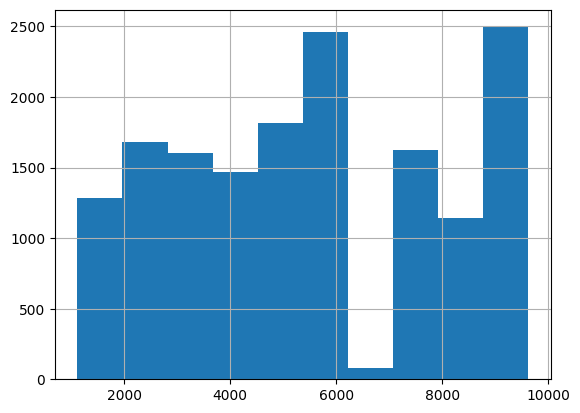

In [192]:
train.target.hist() #классы несбалансированы

Build NN model
---

In [230]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.constraints import MaxNorm
from keras.preprocessing import text, sequence
from keras import utils

train_tags = train.target

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)

num_classes = len(train.target.unique()) + 1
y_train = utils.to_categorical(y_train, num_classes)

batch_size = 64
epochs = 30

# Build the model

model = Sequential()
model.add(Dense(2048, input_shape=(312,)))
model.add(Activation('leaky_relu'))
model.add(Dropout(0.6, input_shape=(312,)))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1
                   )

Epoch 1/30
221/221 [==============================] - 7s 25ms/step - loss: 2.1115 - accuracy: 0.5338 - val_loss: 1.0493 - val_accuracy: 0.7514
Epoch 2/30
221/221 [==============================] - 6s 25ms/step - loss: 0.8639 - accuracy: 0.7959 - val_loss: 0.7231 - val_accuracy: 0.8134
Epoch 3/30
221/221 [==============================] - 6s 26ms/step - loss: 0.6399 - accuracy: 0.8444 - val_loss: 0.5799 - val_accuracy: 0.8575
Epoch 4/30
221/221 [==============================] - 6s 26ms/step - loss: 0.5353 - accuracy: 0.8714 - val_loss: 0.5152 - val_accuracy: 0.8620
Epoch 5/30
221/221 [==============================] - 6s 26ms/step - loss: 0.4684 - accuracy: 0.8875 - val_loss: 0.4729 - val_accuracy: 0.8754
Epoch 6/30
221/221 [==============================] - 6s 25ms/step - loss: 0.4158 - accuracy: 0.8959 - val_loss: 0.4452 - val_accuracy: 0.8920
Epoch 7/30
221/221 [==============================] - 6s 26ms/step - loss: 0.3801 - accuracy: 0.9069 - val_loss: 0.4224 - val_accuracy: 0.8914

Predict test targets
---

In [224]:
x_test = bert_embedder.transform(X_test.full_description.str[:300])
predict_x = model.predict(x_test) 
classes_x = np.argmax(predict_x,axis=1)

35/35 [==============================] - 0s 6ms/step


In [225]:
y_pred = encoder.inverse_transform(classes_x)
y_pred.shape

(1090,)

Preparing submission file
---

In [226]:
submission = test[["index"]].assign(target=y_pred)
display(submission.head(4))
submission.to_csv("C://Users//icom1//submit_fnl.csv", index=False)

,index,target
0,26461447,8322
1,26464220,3323
2,26467473,5223
3,26468989,4110


In [227]:
import kaggle 
SET_KAGGLE_USERNAME= "kyyoto"
SET_KAGGLE_KEY="521387cd2dcddbd071c6e4576bf48476"
!kaggle competitions submit -c bytedatahack-22 -f submit_fnl.csv -m "Message"

Successfully submitted to Хакатон Byte_Data_Hack_22


Error processing line 1 of C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib-3.5.3-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site.py", line 186, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib-3.6.0-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\icom1\AppData\Local\Programs\Python\Python310\lib\site.py", line 186, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored

  0%|    

Win the Hackhaton :)
--- 